Il filtro particellare si articola nel seguente modo:
 #1)Si genera la distribuzione particellare uniforme in maniera casuale 
 #2)Si esegue la predizione del next state delle particelle 
 #3)Si esegue l'aggiornamento
 #4)RESAMPLE
 #5) Si calcola la stima 

 #1)Si genera la distribuzione particellare uniforme in maniera casuale 

In [23]:
from numpy.random import *
import numpy as np
import scipy


def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

#2) Predizione

In [24]:
def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

#3) Aggiornamento

In [25]:
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

#4) Ricampionamento

In [26]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

#5) Stima

In [27]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

def neff(weights):
    return 1. / np.sum(np.square(weights))

è necessario introdurre un metodo di ricampionamento più sofisticato.
FilterPy fornisce diversi metodi di ricampionamento.
Prendono un array di pesi e restituiscono indici alle particelle che sono state scelte per il ricampionamento.
è necessario scrivere solo una funzione che esegua il ricampionamento da questi indici:

In [28]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

Viene plottato un grafico in cui, inizialmente, si definiscono le particelle ed i pesi. Successivamente, si calcola la distanza del robot per ogni punto di riferimento, si incorporano le misure ed, infine, si esegue il ricampionamento.

final position error, variance:
	 [-16.96656119 -16.82098373] [0.00193307 0.00179349]


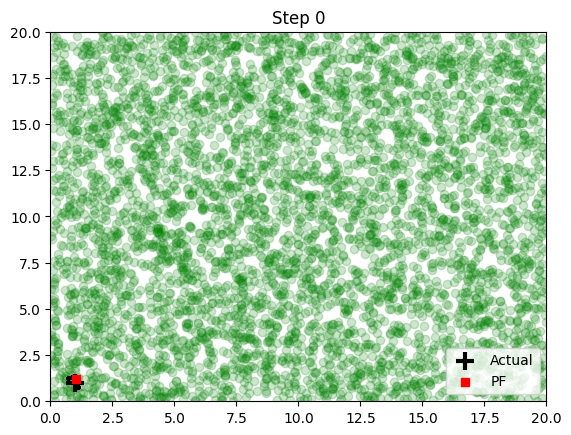

final position error, variance:
	 [-15.99207059 -15.91777467] [0.00123622 0.00244308]


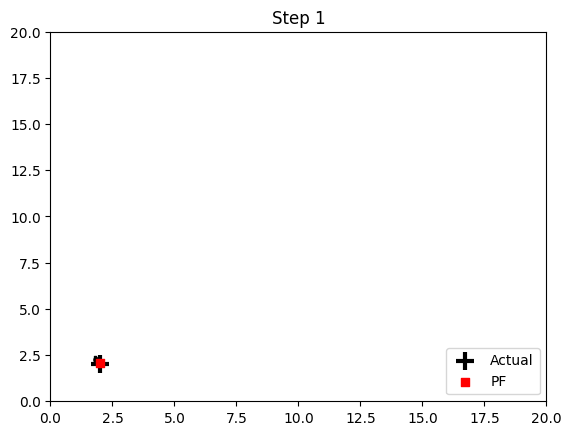

final position error, variance:
	 [-14.82913042 -15.12825237] [0.00620439 0.00776857]


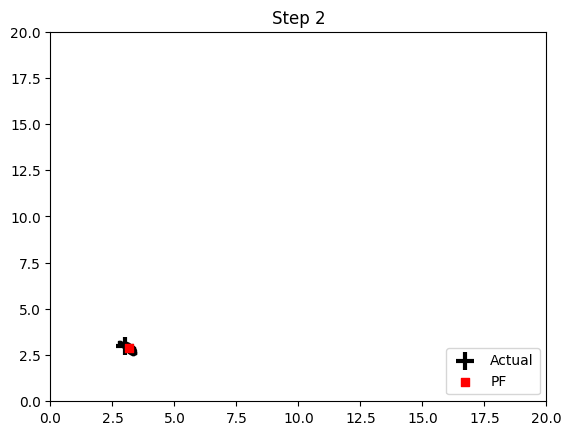

final position error, variance:
	 [-13.92450181 -14.06832181] [0.01068076 0.00830212]


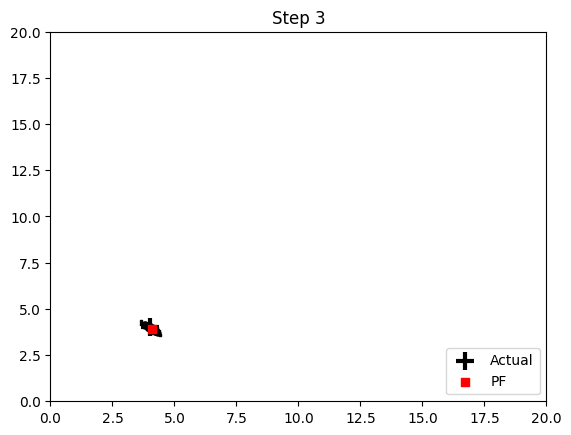

final position error, variance:
	 [-13.09525942 -12.91186491] [0.01078074 0.0068301 ]


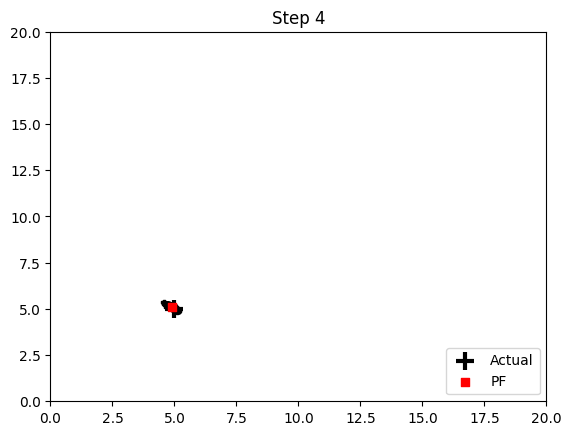

final position error, variance:
	 [-11.98769127 -12.06085867] [0.00736342 0.00589607]


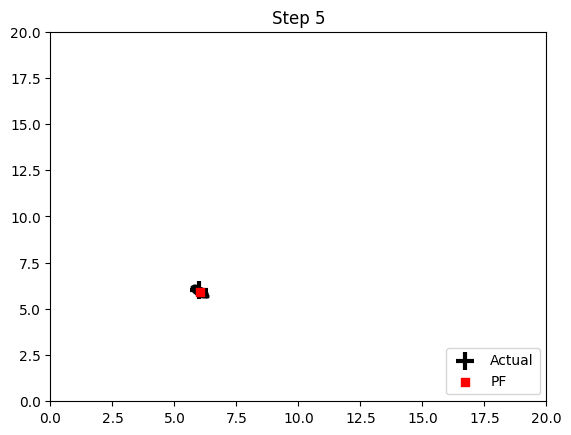

final position error, variance:
	 [-11.10457789 -10.883031  ] [0.00611839 0.00465542]


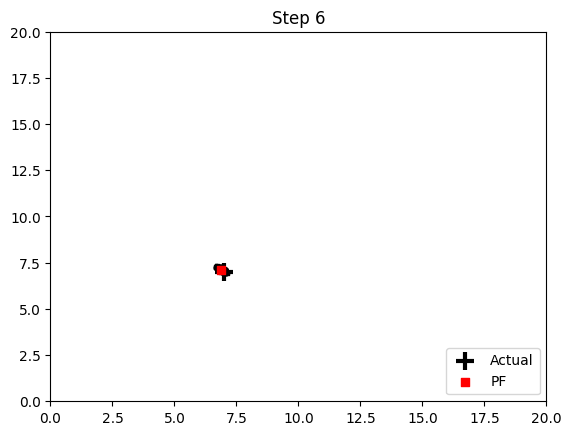

final position error, variance:
	 [-10.01868509 -10.00526306] [0.00515279 0.00559609]


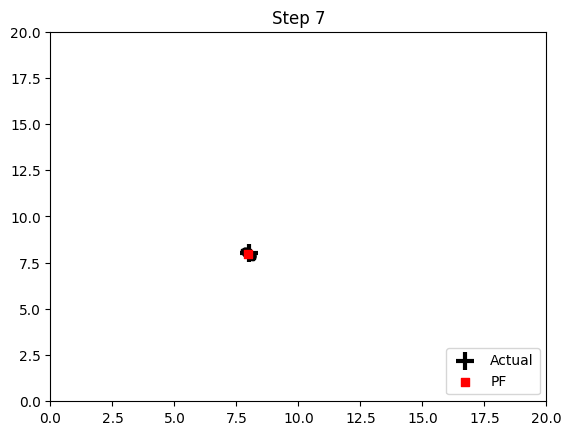

final position error, variance:
	 [-9.01034221 -9.00570157] [0.00563968 0.00690531]


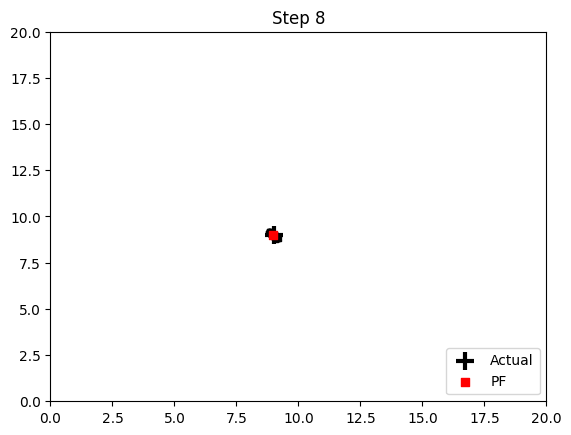

final position error, variance:
	 [-7.98802022 -8.0682185 ] [0.00704397 0.00827452]


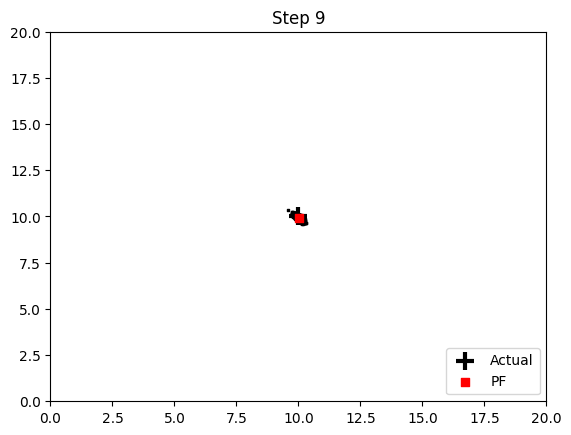

final position error, variance:
	 [-7.07673926 -7.00661563] [0.00912586 0.0087963 ]


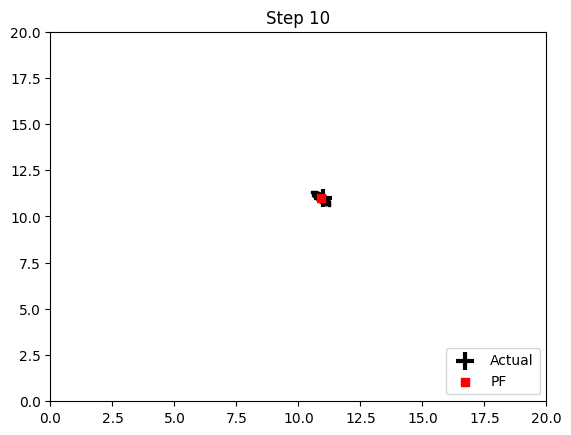

final position error, variance:
	 [-6.09269213 -5.92705744] [0.00710405 0.00607927]


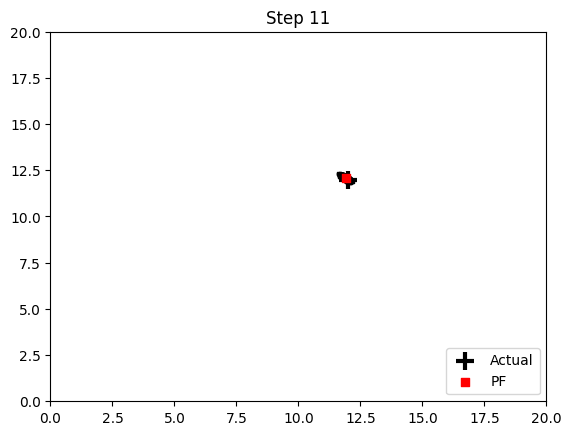

final position error, variance:
	 [-4.94180257 -5.04556681] [0.00439624 0.00520647]


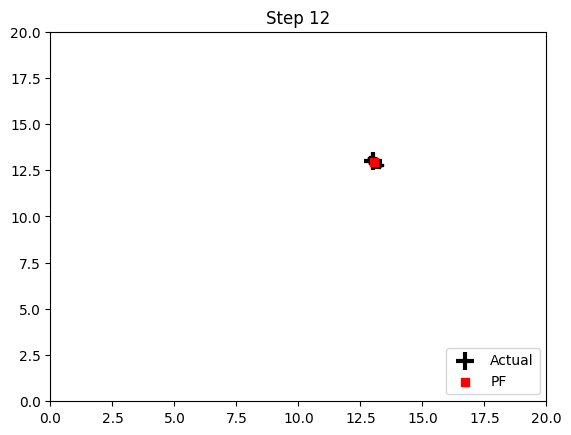

final position error, variance:
	 [-3.99108299 -4.05200532] [0.00661277 0.01010822]


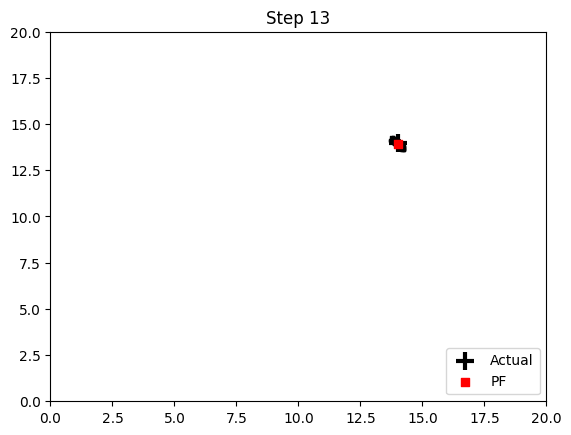

final position error, variance:
	 [-2.85613157 -3.17463527] [0.00794905 0.0129478 ]


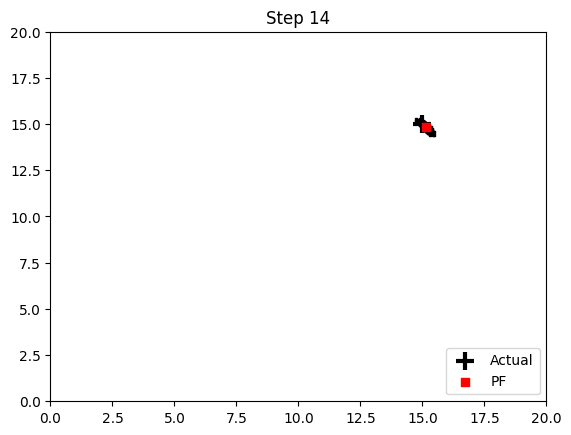

final position error, variance:
	 [-1.81012254 -2.2500647 ] [0.009822  0.0135178]


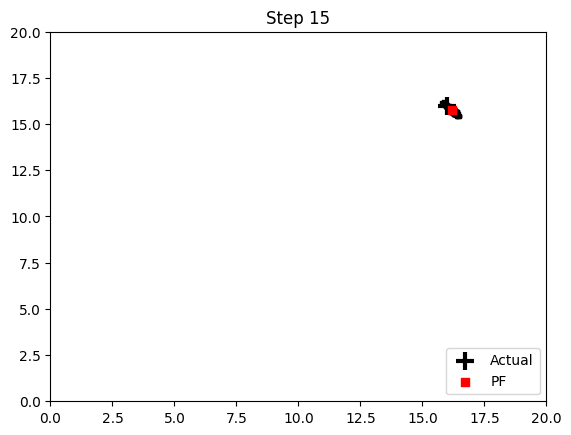

final position error, variance:
	 [-1.04238134 -1.02306599] [0.01101346 0.01088324]


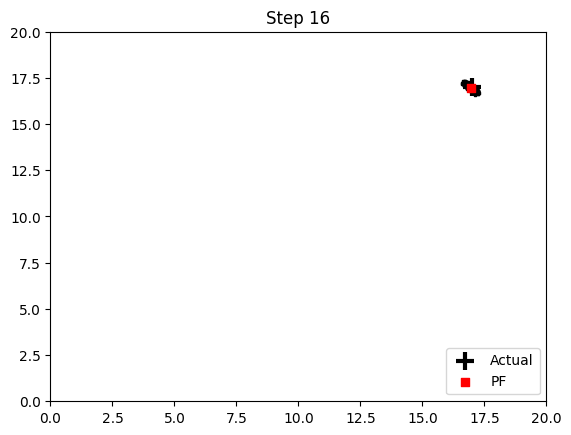

final position error, variance:
	 [-0.10621456  0.1061402 ] [0.00859646 0.00757081]


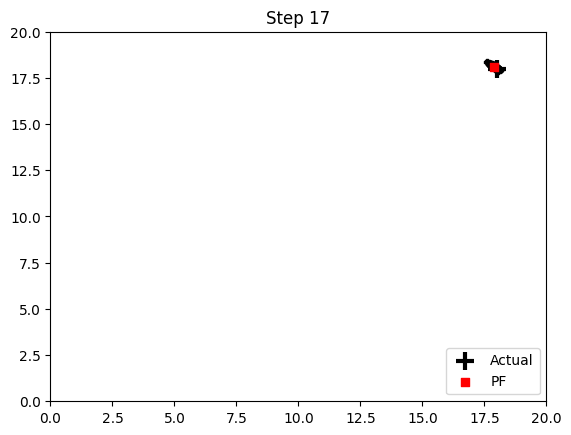

In [29]:
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import matplotlib.pyplot as plt
import scipy.stats

def run_pf1(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]]) #ostacoli
    NL = len(landmarks)
    
    plt.figure()

 # si definiscono particelle e pesi
    if initial_x is not None:
        particles = create_gaussian_particles(
            mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1], 
                    alpha=alpha, color='g')
    
    xs = []
    robot_pos = np.array([0., 0.])
    for x in range(iters):
        plt.title("Step " + str(x))
        robot_pos += (1, 1)

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + 
              (randn(NL) * sensor_std_err))


    # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], 
                        color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
        #xs = np.array(xs)
        #plt.plot(xs[:, 0], xs[:, 1])
        plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
        plt.xlim(*xlim)
        plt.ylim(*ylim)
        print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
        plt.show()

from numpy.random import seed
seed(2) 
run_pf1(N=5000, plot_particles=True)
       
             
    

Di seguito mostriamo il codice completo

In [ ]:
from numpy.random import *
import numpy as np
import scipy


def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

#2) PREDIZIONE

def predict(particles, u, std, dt=1.):

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist
    
#3)UPDATE
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize
    
#4)RESAMPLE
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

#5)STIMA
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var


def neff(weights):
    return 1. / np.sum(np.square(weights))

#è necessario introdurre un metodo di ricampionamento più sofisticato.
# FilterPy fornisce diversi metodi di ricampionamento.
# Prendono un array di pesi e restituiscono indici alle particelle che sono state scelte per il ricampionamento.
# è necessario scrivere solo una funzione che esegua il ricampionamento da questi indici:

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

#create_uniform_particles((0,1), (0,1), (0, np.pi*2), 4)

#Plottiamo un grafico 

from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import matplotlib.pyplot as plt
import scipy.stats

def run_pf1(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]]) #ostacoli
    NL = len(landmarks)
    
    plt.figure()
   
    # create particles and weights
    if initial_x is not None:
        particles = create_gaussian_particles(
            mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1], 
                    alpha=alpha, color='g')
    
    xs = []
    robot_pos = np.array([0., 0.])
    for x in range(iters):
        plt.title("Step " + str(x))
        robot_pos += (1, 1)

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + 
              (randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], 
                        color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
        #xs = np.array(xs)
        #plt.plot(xs[:, 0], xs[:, 1])
        plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
        plt.xlim(*xlim)
        plt.ylim(*ylim)
        print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
        plt.show()

from numpy.random import seed
seed(2) 
run_pf1(N=5000, plot_particles=True)